 # Pokemon Image Clustering #

In [1]:
# for loading/processing the images
from keras.preprocessing.image import load_img
from keras.preprocessing.image import img_to_array 
from keras.applications.vgg16 import preprocess_input
# for other things
import random
import numpy as np
import pandas as pd
import scipy.stats as stats
import matplotlib.pyplot as plt

Using TensorFlow backend.


In [2]:
import os

pokemons = []
rootdir = '../data/PokemonData'
for subdir, dirs, files in os.walk(rootdir):
    for file in files:
        pokemons.append([file, subdir.split('\\')[-1]])
        
print(pokemons[:10])

[['0282b2f3a22745f1a436054ea15a0ae5.jpg', 'Abra'], ['06b9eec4827d4d49b1b4c284308708df.jpg', 'Abra'], ['10a9f06ec6524c66b779ea80354f8519.jpg', 'Abra'], ['1788abb8b51f48509cfac8067bd99e14.jpg', 'Abra'], ['28cfad92ad934d1f9b579cbff4b5d012.jpg', 'Abra'], ['2eb2a528f9a247358452b3c740df69a0.jpg', 'Abra'], ['2fd28e699b7c4208acd1637fbad5df2d.jpeg', 'Abra'], ['32240b108a8140f8b31c495166fc453c.jpg', 'Abra'], ['34532bb006714727ade4075f0a72b92d.jpg', 'Abra'], ['3680c3f65a484c3ba05a7cb93e1d7ae3.jpg', 'Abra']]


In [3]:
pokemon_labels = pd.DataFrame(pokemons, columns = ['FileName', 'Label'])
# credit to https://towardsdatascience.com/how-to-cluster-images-based-on-visual-similarity-cd6e7209fe34
#    for help with image processing
# load the image as a 224x224 array
import matplotlib.image as mpimg
import imghdr
img_list = []
for pokemon in range(len(pokemon_labels)):
    img_path = '../data/PokemonData/'+pokemon_labels.iloc[pokemon]['Label']+'/'+pokemon_labels.iloc[pokemon]['FileName']
    img_type = imghdr.what(img_path)
    if img_type != "png" and img_type != "jpg" and img_type != "jpeg":
        os.remove(img_path)
    else:
        img = load_img(img_path, target_size=(224,224))
        # convert from 'PIL.Image.Image' to numpy array
        img = np.array(img)
        reshaped_img = img.reshape(224,224,3)
        x = preprocess_input(reshaped_img)
        img_list.append([pokemon_labels.iloc[pokemon]['Label'],x])
        #if pokemon_labels.iloc[pokemon]['Label'] in img_dict.keys(): img_dict[pokemon_labels.iloc[pokemon]['Label']].append(np.abs(x))
        #else : img_dict[pokemon_labels.iloc[pokemon]['Label']] = [np.abs(x)]


In [4]:
class img_K_means:
    def __init__(self,img_list,K,dist_func):
        self.imgs       = img_list #dictionary
        self.clustroids = np.asarray(random.sample(self.imgs, K))
        self.centroids  = np.zeros([K,224,224,3])
        self.distances  = np.zeros([K])
        self.clusters   = {}
        self.k = K
        self.dist_func  = dist_func
        for img_tuple in self.clustroids: 
            self.clusters[img_tuple[0]] = [img_tuple]
        
        
    def cluster(self):
        ctr=0
        for img_tuple in self.imgs:      # For each data point
            for j, clustroid_tuple in enumerate(self.clustroids):                       # go through each clustroid
                self.distances[j] = self.squared_dist(clustroid_tuple[1],img_tuple[1])  # and calculate distance to clustroid.
            index = np.argmin(self.distances)                            # Get the index of the closest clustroid
            if self.clustroids[index][0] in self.clusters.keys(): self.clusters[self.clustroids[index][0]].append(img_tuple)
            else: self.clusters[self.clustroids[index][0]] = [img_tuple]   #assign to corresponding cluster

                
                #for tuples in self.clusters[self.clustroids[index]]: print(tuples[0])
                #print("one point assigned: ", img_label, ctr)
                
    def compute_centroids(self):
        new_clusters = {}
        
        for index,cluster in enumerate(self.clusters.keys()):
            
            if index>self.k: break #out of bounds
            centroid = np.zeros([224,224,3])
            
            for img_tuple in self.clusters[cluster]: 
                centroid += np.abs(img_tuple[1])
                
            self.centroids[index] = np.abs(centroid)/len(self.clusters[cluster]) #averages the image RGB's in the cluster list
            ctr=0
            clustroid_tuple=["",np.zeros([224,224,3])]
            distances = np.full((len(self.clusters[cluster])),1000000) #start with large distances so min() doesn't grab 0's
            
            for cluster_tuple in self.clusters[cluster]: 
                distances[ctr] = self.squared_dist(cluster_tuple[1],self.centroids[index])
                if distances[ctr] == min(distances): 
                    clustroid_tuple = cluster_tuple
                ctr+=1
                
            if clustroid_tuple[0] == "": #sometimes clustroid won't get filled by this point. Not sure why, so here's my caveman solution
                clustroid_tuple = random.sample(self.imgs,1)
    
            new_clusters[clustroid_tuple[0]] = [clustroid_tuple] #if we get an error here, collision and thats not great
            self.clustroids[index]  = clustroid_tuple
            
        print(self.k, "clusters:")
        
        for i in self.clusters.keys():print(i,len(self.clusters[i]))
            
        self.clusters.clear()
        self.clusters = new_clusters.copy()
        
    def squared_dist(self,img1,img2):
        return np.sqrt(np.sum((img1-img2)**2))
    
    def fit(self):
        cloysters = self.clusters.copy()
        for i in range(25):
            self.compute_centroids()
            self.cluster()
            if cloysters == self.clusters: break
            cloysters.clear()
            cloysters = self.clusters.copy()
            
                

In [5]:
Ks = [2,5,10,20,50,150]
k_clusters = []
for k in Ks:
    k_cluster = img_K_means(img_list,k,0)
    k_cluster.fit()
    for cluster in k_cluster.clusters.keys():
        print("clustroid:",cluster,"number of imgs in this cluster: ",len(k_cluster.clusters[cluster]))
    k_clusters.append(k_cluster)

C:\Users\Muck\anaconda3\lib\site-packages\numpy\core\_asarray.py:102: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  return array(a, dtype, copy=False, order=order)


2 clusters:
Charizard 1
Machoke 1
2 clusters:
Charizard 3655
Machoke 3166
2 clusters:
Seel 4878
Exeggcute 1943
2 clusters:
Onix 5537
Chansey 1284
clustroid: Onix number of imgs in this cluster:  5537
clustroid: Chansey number of imgs in this cluster:  1284
5 clusters:
Staryu 1
Fearow 1
Abra 1
Dugtrio 1
Gengar 1
5 clusters:
Staryu 5040
Fearow 215
Abra 3
Dugtrio 1275
Gengar 291
5 clusters:
Rhydon 3813
Graveler 1976
Abra 29
Weepinbell 862
Snorlax 144
5 clusters:
Exeggcute 2379
Omanyte 709
Vileplume 1300
Weedle 2095
Clefairy 341
5 clusters:
Exeggcute 1817
Clefairy 5
Koffing 1253
Pidgey 1765
Magnemite 1984
5 clusters:
Chansey 1252
Clefairy 112
Beedrill 1070
Onix 3128
Magneton 1262
5 clusters:
Chansey 1074
Clefairy 112
Hitmonchan 610
Onix 3565
Magneton 1463
5 clusters:
Chansey 971
Clefairy 112
Weezing 738
Onix 3541
Magneton 1462
clustroid: Chansey number of imgs in this cluster:  971
clustroid: Clefairy number of imgs in this cluster:  112
clustroid: Weezing number of imgs in this cluster:  

50 clusters:
Staryu 3
Golem 1065
Persian 63
Jolteon 2
Aerodactyl 17
Onix 822
Graveler 156
Dewgong 13
Haunter 220
Scyther 21
Voltorb 50
Farfetchd 136
Pikachu 2
Primeape 2
Dratini 2
Mew 282
Chansey 337
Kadabra 291
Diglett 1037
Vulpix 440
Seel 100
Tauros 2
Pidgey 479
Exeggcute 299
Grimer 214
Tentacruel 2
Gloom 36
Arcanine 545
Flareon 9
Kabutops 2
Muk 40
Vileplume 157
Shellder 2
Poliwag 1
50 clusters:
Staryu 2
Kangaskhan 69
Persian 56
Jolteon 2
Aerodactyl 12
Onix 704
Weezing 737
Dewgong 11
Beedrill 189
Scyther 19
Haunter 24
Pikachu 2
Primeape 2
Dratini 2
Mew 199
Chansey 292
Kadabra 222
Diglett 1067
Vulpix 350
Seel 90
Tauros 10
Pidgey 341
Exeggcute 270
Dragonair 449
Tentacruel 2
Gloom 20
Goldeen 16
Flareon 9
Kabutops 2
Muk 41
Clefairy 26
Shellder 3
Poliwag 3
Golem 847
Arcanine 612
Vileplume 150
50 clusters:
Staryu 2
Kangaskhan 144
Persian 65
Jolteon 2
Aerodactyl 11
Onix 678
Weezing 335
Dewgong 11
Beedrill 293
Scyther 126
Haunter 47
Pikachu 2
Primeape 2
Dratini 2
Mew 239
Chansey 302
Kadabra 

50 clusters:
Hitmonchan 146
Kangaskhan 70
Persian 64
Jolteon 2
Aerodactyl 9
Onix 530
Weezing 1193
Dewgong 11
Scyther 17
Haunter 58
Pikachu 2
Mewtwo 751
Dratini 2
Mew 219
Chansey 332
Kadabra 227
Rhydon 105
Vulpix 422
Horsea 172
Tauros 3
Pidgey 322
Exeggcute 596
Wartortle 263
Tentacruel 2
Gloom 26
Flareon 9
Kabutops 2
Muk 54
Shellder 3
Weedle 617
Graveler 78
Cubone 68
Butterfree 5
Golem 13
Lickitung 16
Kingler 46
Metapod 18
Electrode 17
Grimer 19
Snorlax 90
Arcanine 260
50 clusters:
Hitmonchan 146
Kangaskhan 69
Persian 64
Jolteon 2
Aerodactyl 9
Onix 530
Weezing 1190
Dewgong 11
Scyther 17
Haunter 58
Pikachu 2
Mewtwo 735
Dratini 2
Mew 219
Chansey 332
Kadabra 227
Rhydon 105
Vulpix 422
Horsea 172
Tauros 3
Pidgey 322
Exeggcute 257
Wartortle 257
Tentacruel 2
Gloom 26
Flareon 9
Kabutops 2
Muk 47
Shellder 3
Weedle 615
Graveler 70
Cubone 68
Butterfree 5
Golem 13
Lickitung 20
Kingler 25
Metapod 25
Electrode 39
Grimer 104
Lapras 360
Arcanine 275
50 clusters:
Hitmonchan 146
Kangaskhan 36
Persian 64


150 clusters:
Goldeen 17
Shellder 3
Staryu 101
Exeggcute 347
Vaporeon 3
Weezing 446
Gyarados 2
Koffing 2
Ditto 61
Electrode 2
Hitmonchan 66
Scyther 65
Gloom 355
Charmander 2
Lickitung 106
Porygon 172
Persian 3
Gastly 6
Sandshrew 3
Kadabra 268
Nidoking 2
Growlithe 2
Omanyte 103
Doduo 13
Dewgong 92
Zapdos 4
Hitmonlee 2
Jigglypuff 2
Tangela 96
Onix 346
Machop 133
Moltres 2
Squirtle 146
Pidgeotto 11
Kangaskhan 99
Seel 66
Omastar 3
Jolteon 2
Voltorb 56
Wartortle 83
Nidoqueen 127
Chansey 323
Victreebel 4
Blastoise 2
Dugtrio 47
Geodude 86
Sandslash 2
Lapras 2
Muk 2
Zubat 5
Pidgeot 2
Snorlax 41
Farfetchd 15
Clefairy 19
Psyduck 28
Magneton 20
Raichu 2
Magikarp 3
Kabutops 62
Ivysaur 2
Ninetales 146
Mewtwo 288
Venomoth 3
Seaking 5
Hypno 26
Rattata 6
Rhydon 23
Nidorino 4
Slowpoke 5
Raticate 5
Cubone 74
Golbat 25
Aerodactyl 3
Oddish 172
MrMime 17
Vileplume 739
Pikachu 2
Diglett 677
Spearow 2
Cloyster 7
Venusaur 10
Golem 150
Graveler 274
Vulpix 109
Starmie 13
Weepinbell 28
150 clusters:
Goldeen 17
S

150 clusters:
Goldeen 17
Shellder 3
Staryu 110
Exeggcute 347
Vaporeon 3
Weezing 448
Gyarados 2
Koffing 2
Ditto 61
Electrode 2
Hitmonchan 57
Scyther 65
Gloom 375
Charmander 2
Lickitung 105
Porygon 176
Persian 114
Gastly 6
Sandshrew 3
Kadabra 207
Nidoking 2
Growlithe 2
Omanyte 103
Doduo 13
Dewgong 35
Zapdos 3
Hitmonlee 2
Jigglypuff 2
Tangela 96
Onix 324
Machop 2
Moltres 2
Squirtle 129
Pidgeotto 6
Kangaskhan 71
Seel 66
Omastar 4
Jolteon 2
Chansey 431
Wartortle 68
Nidoqueen 22
Victreebel 3
Blastoise 2
Dugtrio 369
Geodude 26
Sandslash 415
Lapras 2
Muk 2
Zubat 5
Snorlax 2
Farfetchd 15
Clefairy 18
Psyduck 28
Magneton 19
Raichu 2
Magikarp 2
Kabutops 62
Ivysaur 10
Ninetales 146
Mewtwo 175
Venomoth 3
Seaking 127
Hypno 26
Rattata 6
Rhydon 24
Nidorino 3
Raticate 5
Golbat 26
Aerodactyl 3
MrMime 3
Pikachu 3
Cubone 43
Spearow 2
Venusaur 11
Weedle 148
Butterfree 6
Tauros 22
Mew 1069
Slowpoke 2
Graveler 184
Oddish 13
Vulpix 132
Weepinbell 25
Cloyster 5
Starmie 19
Golem 200
150 clusters:
Goldeen 17
Shel

150 clusters:
Goldeen 17
Shellder 4
Staryu 152
Exeggcute 348
Vaporeon 3
Weezing 821
Gyarados 2
Koffing 2
Ditto 85
Electrode 2
Hitmonchan 59
Scyther 61
Gloom 435
Charmander 2
Lickitung 105
Porygon 173
Persian 112
Gastly 6
Sandshrew 3
Kadabra 190
Nidoking 2
Growlithe 2
Omanyte 110
Doduo 13
Dewgong 77
Zapdos 11
Hitmonlee 2
Jigglypuff 2
Tangela 96
Onix 313
Machop 2
Moltres 2
Squirtle 133
Pidgeotto 6
Kangaskhan 101
Seel 67
Omastar 3
Jolteon 2
Chansey 448
Wartortle 67
Nidoqueen 112
Victreebel 3
Blastoise 2
Geodude 77
Sandslash 2
Lapras 2
Muk 145
Zubat 5
Snorlax 2
Farfetchd 188
Clefairy 19
Psyduck 29
Magneton 19
Raichu 2
Magikarp 3
Kabutops 67
Ivysaur 7
Ninetales 151
Mewtwo 274
Venomoth 3
Seaking 163
Hypno 31
Rattata 8
Rhydon 25
Raticate 6
Golbat 27
Aerodactyl 3
MrMime 28
Pikachu 3
Cubone 40
Spearow 2
Venusaur 10
Weedle 159
Butterfree 6
Tauros 25
Dugtrio 346
Vulpix 198
Diglett 4
Oddish 69
Weepinbell 30
Golem 268
Graveler 267
Starmie 20
Cloyster 2
Nidorino 2
Slowpoke 4
150 clusters:
Goldeen 17

In [6]:
for k_cluster in k_clusters:
    print(k_cluster.clusters.keys())

dict_keys(['Onix', 'Chansey'])
dict_keys(['Chansey', 'Clefairy', 'Weezing', 'Onix', 'Magneton'])
dict_keys(['Chansey', 'Onix', 'Magneton', 'Weezing', 'Wigglytuff', 'Exeggcute', 'Pidgey', 'Weepinbell', 'Nidorino', 'Spearow'])
dict_keys(['Dratini', 'Horsea', 'Goldeen', 'Hitmonchan', 'Wartortle', 'Exeggcute', 'Sandshrew', 'Pidgey', 'Dewgong', 'Ivysaur', 'Onix', 'Caterpie', 'Oddish', 'Venusaur', 'Chansey'])
dict_keys(['Hitmonchan', 'Kangaskhan', 'Persian', 'Jolteon', 'Aerodactyl', 'Onix', 'Weezing', 'Dewgong', 'Scyther', 'Haunter', 'Pikachu', 'Mewtwo', 'Dratini', 'Mew', 'Chansey', 'Kadabra', 'Rhydon', 'Vulpix', 'Horsea', 'Tauros', 'Pidgey', 'Exeggcute', 'Wartortle', 'Tentacruel', 'Gloom', 'Flareon', 'Kabutops', 'Muk', 'Shellder', 'Weedle', 'Graveler', 'Cubone', 'Butterfree', 'Golem', 'Lickitung', 'Kingler', 'Metapod', 'Electrode', 'Arcanine'])
dict_keys(['Goldeen', 'Shellder', 'Staryu', 'Exeggcute', 'Vaporeon', 'Weezing', 'Gyarados', 'Koffing', 'Ditto', 'Electrode', 'Hitmonchan', 'Scyther'

In [12]:
k_cluster = img_K_means(img_list,10,0)
k_cluster.fit()
for cluster in k_cluster.clusters.keys():
        print("clustroid:",cluster,"number of imgs in this cluster: ",len(k_cluster.clusters[cluster]))
print(k_cluster.clusters)

C:\Users\tanne\Anaconda3\lib\site-packages\numpy\core\_asarray.py:83: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  return array(a, dtype, copy=False, order=order)


10 clusters:
Aerodactyl 1
Nidorino 1
Raticate 1
Bulbasaur 1
Paras 1
MrMime 1
Tangela 1
Tentacool 1
Jigglypuff 1
Goldeen 1
10 clusters:
Aerodactyl 390
Nidorino 1136
Raticate 6
Bulbasaur 206
Paras 2104
MrMime 19
Tangela 52
Tentacool 87
Jigglypuff 145
Goldeen 2684
10 clusters:
Aerodactyl 348
Gastly 2125
Victreebel 91
Oddish 201
Chansey 1242
Growlithe 14
Shellder 87
Nidorina 133
Onix 2587
10 clusters:
Diglett 2310
Grimer 987
Spearow 176
Bellsprout 255
Chansey 1024
Shellder 295
Tangela 228
Onix 1552
10 clusters:
Rattata 534
Nidoqueen 2649
Hitmonchan 205
Kadabra 681
Chansey 746
Weezing 402
Oddish 338
Rhydon 345
Onix 927
10 clusters:
Rhydon 1412
Horsea 1997
Hitmonchan 205
Kadabra 734
Chansey 746
Weezing 397
Oddish 337
Onix 999
10 clusters:
Rhydon 337
Mewtwo 3166
Hitmonchan 208
Kadabra 897
Chansey 746
Weezing 401
Oddish 338
Onix 734
10 clusters:
Rhydon 344
Wartortle 3051
Hitmonchan 200
Kadabra 887
Chansey 746
Weezing 387
Oddish 337
Onix 875
clustroid: Rhydon number of imgs in this cluster:  34

IOPub data rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_data_rate_limit`.

Current values:
NotebookApp.iopub_data_rate_limit=1000000.0 (bytes/sec)
NotebookApp.rate_limit_window=3.0 (secs)



Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


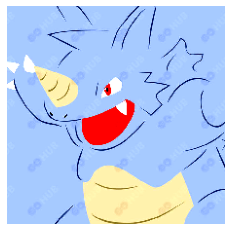

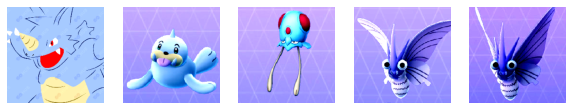

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


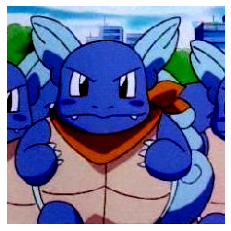

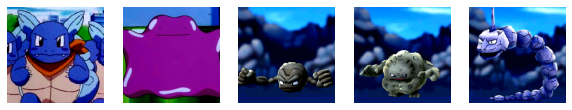

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


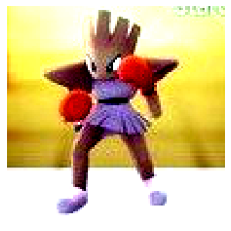

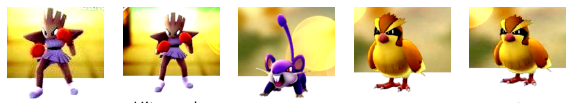

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


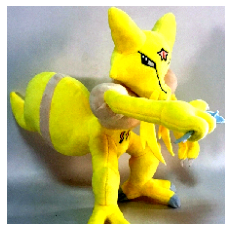

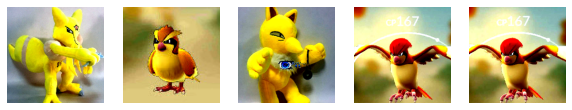

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


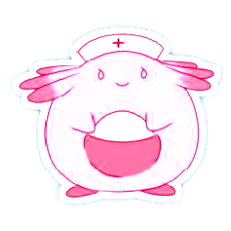

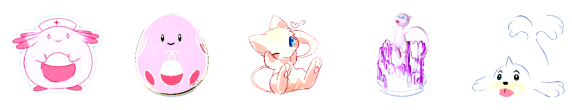

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


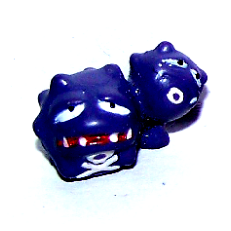

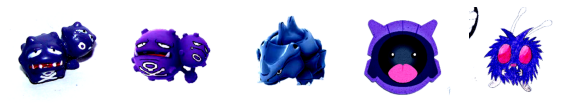

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


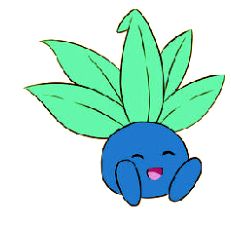

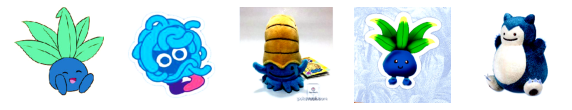

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


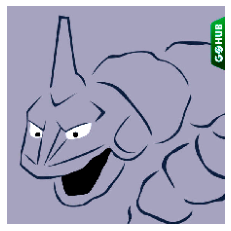

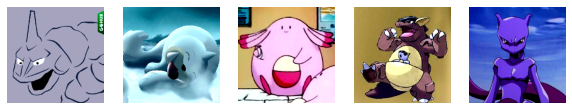

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


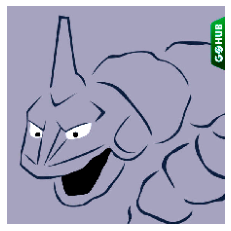

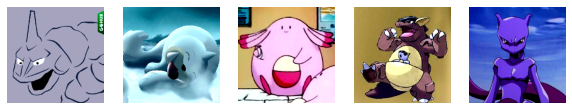

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


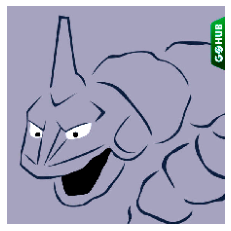

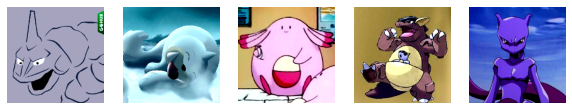

In [13]:
def sq_dist(img1,img2):
        return np.sqrt(np.sum((img1-img2)**2))

def n_closest(rgbs, clustroid, n):
    closest = []
    for rgb in rgbs:
        if len(closest) < n:
            closest.append(rgb[1])
        else:
            for c in range(n):
                dist = sq_dist(rgb[1], clustroid)
                if dist < sq_dist(closest[c], clustroid) and dist > 0.1:
                    closest[c] = rgb[1]
                    break
    return closest
                    

for clustroid in k_cluster.clustroids:
    plt.imshow(clustroid[1][:,:,::-1]/100)
    plt.xticks([])
    plt.yticks([])
    plt.axis('off')
    closest = n_closest(k_cluster.clusters[clustroid[0]], clustroid[1], 5)
    if len(k_cluster.clusters[clustroid[0]]) > 5:
        f, axarr = plt.subplots(1,5, figsize = (10, 15))
    else:
        f, axarr = plt.subplots(1,len(k_cluster.clusters[clustroid[0]]))
    for index, img in enumerate(closest):
        #print(img)
        axarr[index].imshow(img[:,:,::-1]/100)
    for ax in axarr:
        ax.set_xticks([])
        ax.set_yticks([])
        ax.axis('off')
    plt.show()